# Import Drivers+, Download Overlay

In [233]:
import logging
import sys
import pynq
import time
from pynq import PL

import numpy as np
from fpbinary import FpBinary
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq, fftshift
import scipy.io as sio

import mkidgen3 as g3
import mkidgen3.mkidpynq as mkidpynq
import mkidgen3.util
import mkidgen3.plotting
from mkidgen3.plotting import plot_waveforms, plot_res_chan
from mkidgen3.daccomb import generate_dac_comb
from mkidgen3.drivers import axiswitch, bintores, capture, ddc, dactable, axififo, rfdc
from mkidgen3.drivers.ifboard import IFBoard
from mkidgen3.testutils import *

In [234]:
#from logging import getLogger, basicConfig
#basicConfig()
#getLogger("mkidgen3.drivers.ifboard").setLevel("DEBUG")

In [235]:
# Download Overlay, Optionally Configure Clocks
bitstream='/home/xilinx/bit/22_1_rebuild.bit'
ol = g3.overlay_helpers.configure(bitstream, ignore_version=True, clocks=True, external_10mhz=True, download=True)

In [237]:
bram_mmio = ol.photon_pipe.reschan.axi_bram_ctrl_0.mmio

In [238]:
#ol.photon_pipe.reschan.resonator_ddc=ol.photon_pipe.reschan.resonator_ddc_control

# Results

'/home/xilinx/bit/full_design_3core.bit' passes all except optimal filters

'/home/xilinx/bit/vivado_2021_2.bit' passess all

'/home/xilinx/bit/vivado_2022_1.bit' passes all

'/home/xilinx/bit/vivado_2022_1.bit' passes all except optimal filters

# Play Waveform

In [239]:
#Set tones to send (in Hz). Domain is [-2047,2048) MHz. Set the SNR for a noise floor, `'max'` will turn off noise.
tones = np.array([200e6+107e3, 300.5e6-33e3, 400e6+20e3]) 
amplitudes = np.ones_like(tones)/tones.shape[0]
g3.set_waveform(tones,amplitudes,fpgen='simple')

{'iq': array([ 0.1167369 -0.44299346j,  0.39488313-0.37023562j,
         0.6071889 -0.13852721j, ..., -0.25814435+0.06377825j,
        -0.26704618-0.15864147j, -0.13020271-0.35545525j], dtype=complex64),
 'frequencies': array([2.00109375e+08, 3.00468750e+08, 4.00023438e+08]),
 'phases': array([0.59499012, 4.69096957, 4.2383029 ])}

# ADC CAPTURE

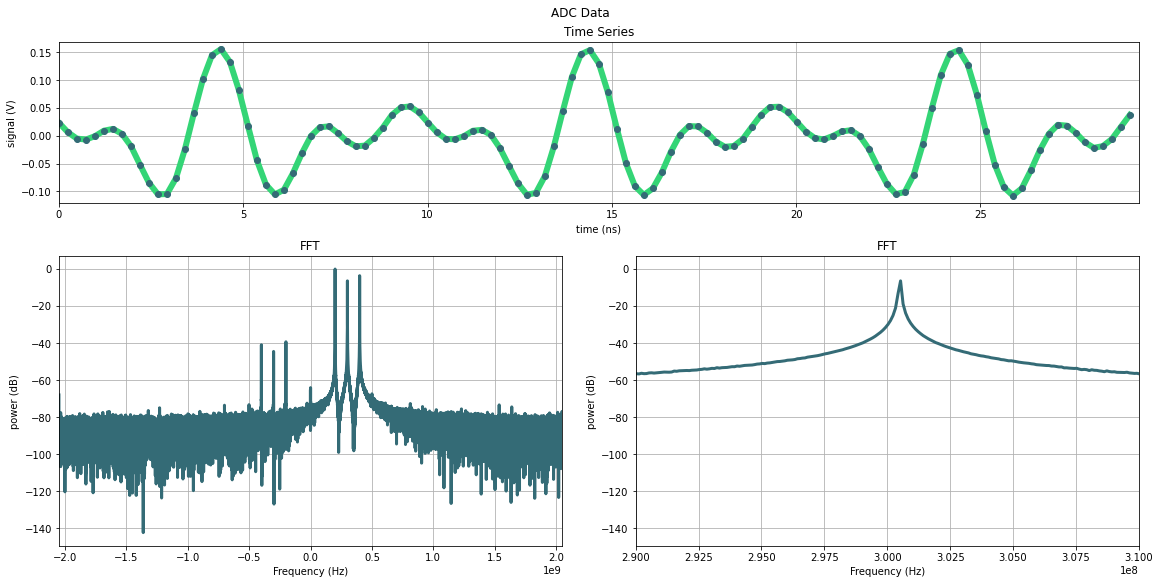

In [241]:
# Trigger Capture
ol.capture.capture_adc(2**19, complex=True) # throw away capture to clear any startup garbage
adc_capture_data = ol.capture.capture_adc(2**19, complex=True)
adc_capture_data/=2**16  #Normalize to 1/2 V
# Plot ADC Data
timerange = (0,120)  # ns
fftrange= (16, 16 + 20*4096) 
fftzoom = (2.9e8, 3.1e8)
mkidgen3.plotting.adc_test_plot(adc_capture_data, timerange, fftrange, fftzoom)

## Assign Resonator Channels

In [242]:
bins = np.zeros(2048, dtype=int)
bins[:tones.size] = g3.opfb_bin_number(tones,ssr_raw_order=True)
ol.photon_pipe.reschan.bin_to_res.bins = bins

## Program DDC

In [243]:
ddc_driver_ob =  mkidgen3.drivers.ddc.ThreepartDDC(bram_mmio)

In [244]:
ddc_tones = np.zeros(2048)
ddc_tones[:tones.size]=tones
ddc_driver_ob.configure_ddc(ddc_tones)  #phase goes from [-pi, pi), like tones.size

# Capture Phase

901 901


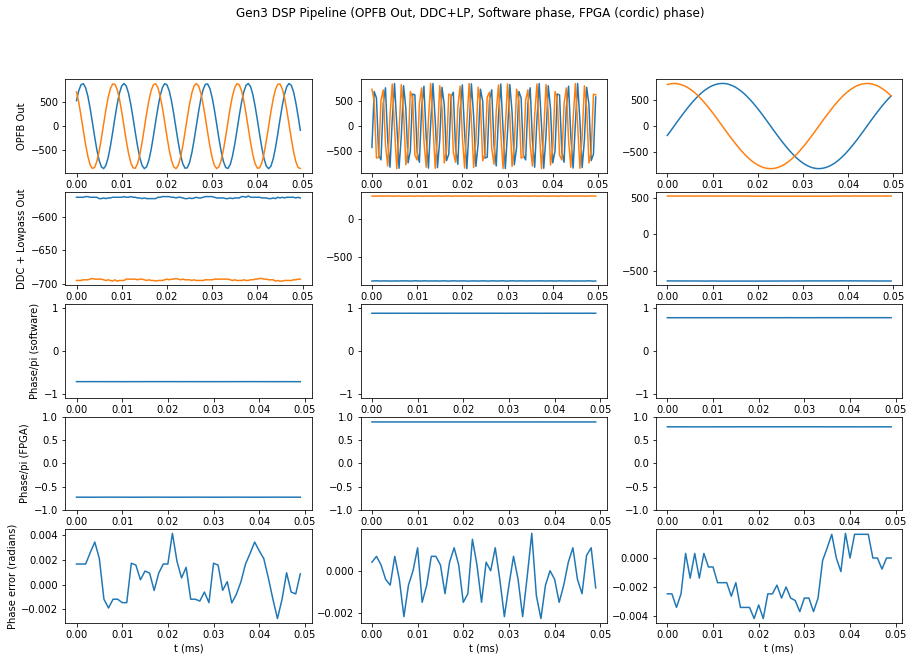

In [245]:
riq, iq = ol.capture.ddc_compare_cap()
iq, phase = ol.capture.cap_cordic_compare()
tonesplt = tones
chan_plt=[0,1,2]
bin_centers = g3.opfb_bin_center(g3.opfb_bin_number(tonesplt, ssr_raw_order=True), ssr_order=True)
fig, axes = plt.subplots(5,3, figsize=(15,10))
tones_khz=g3.drivers.ddc.tone_increments(tonesplt, quantize=True)*1e3
for j,(i, ax) in enumerate(zip(chan_plt,axes.T)):
    plot_waveforms(riq[:100, i], 2e6, ax=ax[0], label='OPFB Out' if not j else '')
    plot_waveforms(iq[:100, i], 2e6, sw_phase=False, ax=ax[1], label='DDC + Lowpass Out' if not j else '')
    plot_waveforms(iq[:50, i], 1e6, sw_phase = True, ax=ax[2], label='Phase/pi (software)' if not j else '')
    plot_waveforms(phase[:50, i]/2**15, 1e6, cordic=True, ax=ax[3], label='Phase/pi (FPGA)' if not j else '')
    plt.ylim([-1,1])
    err=np.angle(iq[:50, i])-np.pi*phase[:50, i]/2**15
    plot_waveforms(err, 1e6, cordic=True, ax=ax[4], label='Phase error (radians)' if not j else '')
    #plt.ylim([-1,1])
plt.suptitle('Gen3 DSP Pipeline (OPFB Out, DDC+LP, Software phase, FPGA (cordic) phase)');

# Centering

In [246]:
centers = np.zeros(2048, dtype=np.complex64)
phase_offsets=np.zeros(2048)
ddc_driver_ob.configure_ddc(ddc_tones, phase_offsets, centers)

In [247]:
_, iq_uncentered = ol.capture.ddc_compare_cap()

901 901


In [248]:
centers = np.zeros(2048, dtype=np.complex64)
phase_offsets=np.zeros(2048)
centers[0:3] = [0+0.5*1j, 0-0.5*1j, 0.5+0*1j]

In [249]:
ddc_driver_ob.configure_ddc(ddc_tones, phase_offsets, centers)

In [250]:
_, iq_centered = ol.capture.ddc_compare_cap()

901 17089


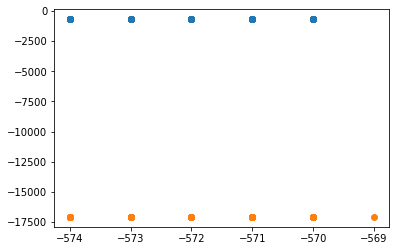

In [251]:
plt.plot(iq_uncentered[:,0].real, iq_uncentered[:,0].imag, "o")
plt.plot(iq_centered[:,0].real, iq_centered[:,0].imag, "o")

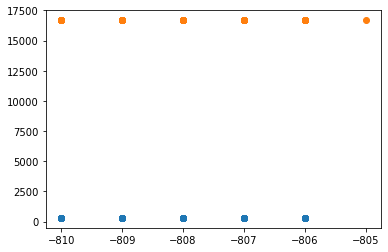

In [252]:
plt.plot(iq_uncentered[:,1].real, iq_uncentered[:,1].imag, "o")
plt.plot(iq_centered[:,1].real, iq_centered[:,1].imag, "o")

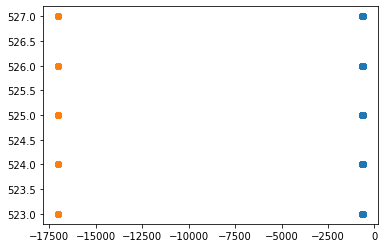

In [253]:
plt.plot(iq_uncentered[:,2].real, iq_uncentered[:,2].imag, "o")
plt.plot(iq_centered[:,2].real, iq_centered[:,2].imag, "o")

## Optimal Filter

In [254]:
unity=np.zeros(30, dtype=np.int16)
unity[0] = 2**15-1

In [267]:
## RAW
phases={}
n_points=1024
x = ol.capture.capture_phase(n_points, [0,1], tap_location='rawphase')
phases['raw']=np.array(x)
x.freebuffer()

## LOAD UNITY FILTER EVERY CHANNEL
ol.photon_pipe.phasematch.load_coeff(0,unity, vet=False, raw=True)
ol.photon_pipe.phasematch.load_coeff(1,unity, vet=False, raw=True)
ol.photon_pipe.phasematch.load_coeff(2,unity, vet=False, raw=True, force_commit=True)
time.sleep(1)
# Capture
x = ol.capture.capture_phase(n_points, 'all', tap_location='phase')
phases['unity']=np.array(x)
x.freebuffer()

/home/xilinx/src/mkidgen3/mkidgen3/drivers/axififo.py:43: RuntimeWarning: coroutine 'Interrupt.wait' was never awaited
  self.interrupt.wait()  # wait for the transmit to complete


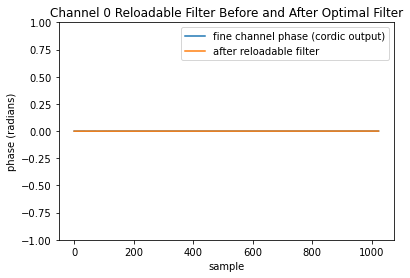

In [268]:
plt.plot(phases['raw'][:,0]/(2**15-1))
plt.plot((phases['unity'][::,0])/(2**15-1))
plt.ylim([-1,1]);
plt.xlabel('sample')
plt.ylabel('phase (radians)')
plt.legend(['fine channel phase (cordic output)', 'after reloadable filter'])
plt.title('Channel 0 Reloadable Filter Before and After Optimal Filter');

# Bias Phase

In [259]:
phase_offsets = np.zeros(2048)
ddc_centers = np.zeros(2048, dtype=np.complex64)
ddc_driver_ob.configure_ddc(ddc_tones, phase_offsets, ddc_centers, center_relative=False, quantize=True)

In [260]:
x = ol.capture.capture_phase(2**19, [0,1], tap_location='rawphase')
phase = np.array(x)
x.freebuffer()
raw_phase1 = phase[:,0]/(2**15-1)
raw_phase2 = phase[:,1]/(2**15-1)
raw_phase3 = phase[:,2]/(2**15-1)

In [261]:
phase_offsets[:tones.size]=[-np.average(raw_phase1)*np.pi, -np.average(raw_phase2)*np.pi, -np.average(raw_phase3)*np.pi]
#phase_offsets = None
ddc_driver_ob.configure_ddc(ddc_tones, phase_offsets, ddc_centers, center_relative=False, quantize=True)

In [262]:
phase_offsets

array([ 2.2601522 , -2.78431952, -2.45726154, ...,  0.        ,
        0.        ,  0.        ])

In [263]:
x = ol.capture.capture_phase(2**19, [0,1], tap_location='rawphase')
phase = np.array(x)
x.freebuffer()
moved_phase1 = phase[:,0]/(2**15-1)
moved_phase2 = phase[:,1]/(2**15-1)
moved_phase3 = phase[:,2]/(2**15-1)

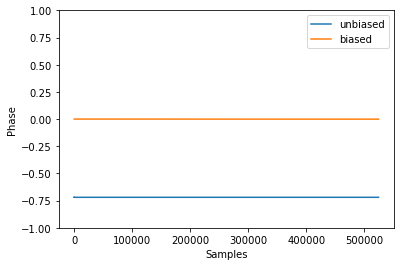

In [264]:
plt.plot(raw_phase1)
plt.plot(moved_phase1)
plt.ylim([-1,1]);
plt.ylabel('Phase')
plt.xlabel('Samples')
plt.legend(['unbiased','biased']);

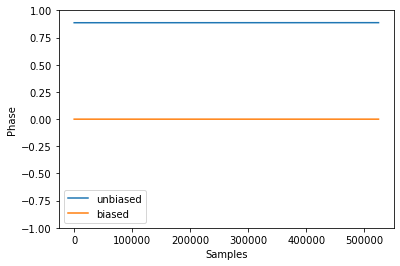

In [265]:
plt.plot(raw_phase2)
plt.plot(moved_phase2)
plt.ylim([-1,1]);
plt.ylabel('Phase')
plt.xlabel('Samples')
plt.legend(['unbiased','biased']);

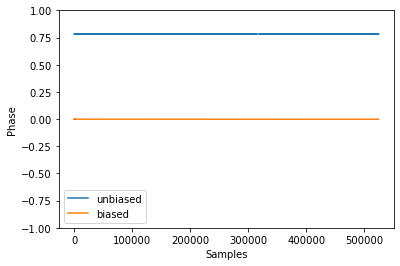

In [266]:
plt.plot(raw_phase3)
plt.plot(moved_phase3)
plt.ylim([-1,1]);
plt.ylabel('Phase')
plt.xlabel('Samples')
plt.legend(['unbiased','biased']);